In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [15]:
import sklearn.datasets as data
from sklearn.model_selection import train_test_split

In [16]:
X,y=data.make_blobs(n_features=40,n_samples=1000,centers=4,random_state=42,cluster_std=1.8)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [17]:
X_train=torch.Tensor(X_train)
X_test=torch.Tensor(X_test)
y_train=torch.Tensor(y_train)
y_test=torch.Tensor(y_test)

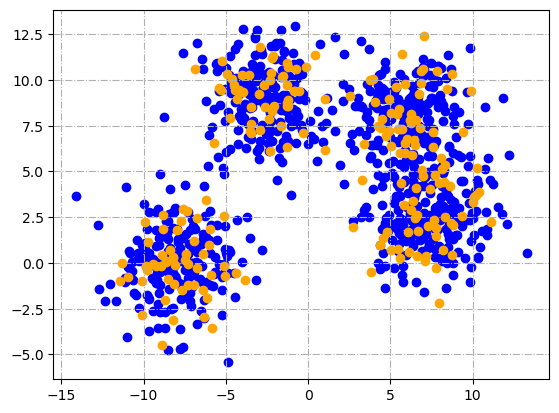

In [18]:
plt.scatter(X_train[:,0],X_train[:,1],c='b')
plt.scatter(X_test[:,0],X_test[:,1],c='orange')
plt.grid(linestyle='-.')
plt.show()

In [19]:
class AutoEncoder(nn.Module):
    def __init__(self,input_dim,hidden_dim,enc_dim):
        super().__init__()
        
        self.encoder=nn.Sequential(nn.Linear(input_dim,hidden_dim*2),
                                  nn.ReLU(),
                                   nn.AlphaDropout(p=0.2),
                                  nn.Linear(hidden_dim*2,hidden_dim),
                                  nn.ReLU(),
                                   nn.AlphaDropout(p=0.2),
                                  nn.Linear(hidden_dim,enc_dim))
        
        self.decoder=nn.Sequential(nn.Linear(enc_dim,hidden_dim),
                                  nn.ReLU(),
                                   nn.AlphaDropout(p=0.2),
                                  nn.Linear(hidden_dim,hidden_dim*2),
                                  nn.ReLU(),
                                   nn.AlphaDropout(p=0.2),
                                  nn.Linear(hidden_dim*2,input_dim))
        
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        
        return encoded,decoded

In [20]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self,input_dim,hidden_dim,latent_dim):
        super().__init__()
        
        self.latent_dim=latent_dim
        
        # ALPHA DROPOUT USED TO PROMOTE SPARSITY IN MODEL VIA MULTIPLICATIVE NOISE
        # LEAKY RELU USED TO PREVENT VANISHING GRADIENT
        # REGULARIZATION WILL BE USED IN TANDEM WITH ALPHA DROPOUT

        self.encoder=nn.Sequential(nn.Linear(input_dim,hidden_dim),
                                  nn.LeakyReLU(),
                                   nn.AlphaDropout(p=0.3),
                                  nn.Linear(hidden_dim,hidden_dim),
                                  nn.LeakyReLU(),
                                   nn.AlphaDropout(p=0.3),
                                  nn.Linear(hidden_dim,latent_dim*2))
        
        self.decoder=nn.Sequential(nn.Linear(latent_dim,hidden_dim),
                                  nn.LeakyReLU(),
                                   nn.AlphaDropout(p=0.3),
                                  nn.Linear(hidden_dim,hidden_dim),
                                  nn.LeakyReLU(),
                                   nn.AlphaDropout(p=0.3),
                                  nn.Linear(hidden_dim,input_dim))
        
    def reparameterize(self,mu,log_var):
        std=torch.exp(0.5*log_var)
        eps=torch.randn_like(std)
        return mu+std*eps
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        
        # EXTRACT DIST PARAMETERS FROM ENC OUTPUT
        enc_out=self.encoder(x)
        mu=enc_out[:,:self.latent_dim]
        log_var=enc_out[:,self.latent_dim:]
        
        # REPARAMETERIZE AND DRAW FROM DIST TO RECONSTRUCT
        z=self.reparameterize(mu,log_var)
        
        x_rec=self.decoder(z)
        
        return x_rec,mu,log_var

In [21]:
from torch.utils.data import TensorDataset,DataLoader
dataset=TensorDataset(X_train)

batch_size=20
loader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=False)

In [22]:
auto=AutoEncoder(input_dim=40,hidden_dim=32,enc_dim=5)
optim1=torch.optim.RMSprop(auto.parameters(),lr=3e-4)

In [24]:
vae=VariationalAutoEncoder(input_dim=40,hidden_dim=20,latent_dim=8)
total=0.0
loss_fn=nn.MSELoss()
optim=torch.optim.Adam(vae.parameters(),lr=2e-3,weight_decay=1e-3)

In [25]:
epochs=50
for epoch in range(epochs):
    i=0
    total=0
    for batch in loader:
        auto.train()
        batch=batch[0]
        enc,dec=auto(batch)
        loss=loss_fn(batch,dec)


        # USE MANHATTAN NORM TO REGULARIZE THE PARAMETERS
        l1_norm=0
        for param in vae.parameters():
            l1_norm+=torch.norm(param,1)
            
        loss+=l1_norm
        total+=0.4*loss
        
        optim1.zero_grad()
        loss.backward()
        optim1.step()
        
        i+=1
    
    total/=i
    
    if epoch%2==0:
        print(f"Epoch: {epoch:2d} || Mean Training Loss: {total:.7f}")

Epoch:  0 || Mean Training Loss: 142.9490051
Epoch:  2 || Mean Training Loss: 138.1433105
Epoch:  4 || Mean Training Loss: 136.6408386
Epoch:  6 || Mean Training Loss: 134.1265869
Epoch:  8 || Mean Training Loss: 133.1279144
Epoch: 10 || Mean Training Loss: 132.3176270
Epoch: 12 || Mean Training Loss: 131.9251556
Epoch: 14 || Mean Training Loss: 131.7612457
Epoch: 16 || Mean Training Loss: 131.7005920
Epoch: 18 || Mean Training Loss: 131.5751190
Epoch: 20 || Mean Training Loss: 131.4203491
Epoch: 22 || Mean Training Loss: 131.4172821
Epoch: 24 || Mean Training Loss: 131.2783051
Epoch: 26 || Mean Training Loss: 131.2718506
Epoch: 28 || Mean Training Loss: 131.2676697
Epoch: 30 || Mean Training Loss: 131.1990051
Epoch: 32 || Mean Training Loss: 131.1678162
Epoch: 34 || Mean Training Loss: 131.1853027
Epoch: 36 || Mean Training Loss: 131.0820007
Epoch: 38 || Mean Training Loss: 131.0048523
Epoch: 40 || Mean Training Loss: 131.1035767
Epoch: 42 || Mean Training Loss: 131.0228577
Epoch: 44 

In [26]:
epochs=10
for epoch in range(epochs):
    i=0
    total=0
    total_rec=0
    total_kl=0
    
    for batch in loader:
        vae.train()
        batch=batch[0]
        batch=batch.reshape(-1,40)
        x_rec,mu,log_var=vae(batch)
        
        l2_norm=0
        for param in vae.parameters():
            l2_norm+=torch.norm(param,2)**2

        #CALCULATE RECONSTRUCTION LOSS AND DIVERGENCE
        rec_loss=loss_fn(x_rec,batch)
        kl_div=-0.5*torch.sum(1+log_var-mu.pow(2)-log_var.exp())

        # FIND THE EVIDENCE LOWER BOUND ELBO  AND REGULARIZE WITH L2 NORM
        elbo=kl_div+rec_loss
        elbo+=0.2*l2_norm
        
        # APPEND METRICS TO THE TOTAL OF ALL BATCHES
        total_rec+=rec_loss
        total_kl+=kl_div
        total+=elbo

        
        optim.zero_grad()
        elbo.backward()
        optim.step()
        i+=1
    
    total/=i
    total_rec/=i
    total_kl/=i
#     with torch.inference_mode():
#         vae.eval()
#         x_rec,mu,log_var=vae(X_test)
#         test_loss=loss_fn(x_rec,X_test)
#         kl_div= -0.5*torch.sum(1+log_var-mu.pow(2)-log_var.exp())
#         test_loss+=kl_div
        
    if epoch%1==0:
        print(f"Epoch: {epoch:2d} || Loss: {total:.7f} || Rec. Loss: {total_rec:.7f} \
        || KL div: {total_kl:.7f}\n")

Epoch:  0 || Loss: 56.1589127 || Rec. Loss: 38.3574219         || KL div: 17.8014851

Epoch:  1 || Loss: 44.0676651 || Rec. Loss: 37.3655968         || KL div: 6.7020707

Epoch:  2 || Loss: 37.9849014 || Rec. Loss: 35.4787788         || KL div: 2.5061159

Epoch:  3 || Loss: 33.6719894 || Rec. Loss: 32.7959366         || KL div: 0.8760523

Epoch:  4 || Loss: 31.0426731 || Rec. Loss: 30.7348671         || KL div: 0.3078021

Epoch:  5 || Loss: 30.4993858 || Rec. Loss: 30.3832283         || KL div: 0.1161634

Epoch:  6 || Loss: 30.4441032 || Rec. Loss: 30.4009800         || KL div: 0.0431297

Epoch:  7 || Loss: 30.1778564 || Rec. Loss: 30.1593723         || KL div: 0.0184836

Epoch:  8 || Loss: 30.0484772 || Rec. Loss: 30.0393925         || KL div: 0.0090872

Epoch:  9 || Loss: 29.8902130 || Rec. Loss: 29.8852882         || KL div: 0.0049302



In [ ]:
# f=torch.randint(0,800,(1,15))

In [ ]:
# zeta=torch.zeros([800,2])
# for i in range(800):
#     x_rec,mu,sigma=vae(X_train)
#     zeta[i]=x_rec

In [27]:
enc,dec=auto(X_train)
beta=dec

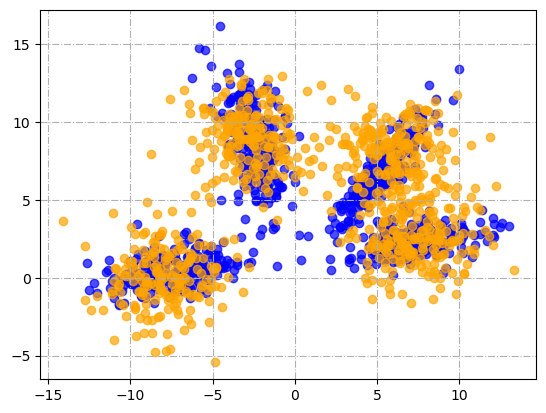

In [28]:
# AUTOENCODER SEEMS TO LEARN MORE LITERALLY CAPTURING SOME UNDERLYING GROUPS

plt.scatter(beta[:,0].detach().numpy(),beta[:,1].detach().numpy(),color='b',alpha=0.7)
plt.scatter(X_train[:,0].detach().numpy(),X_train[:,1].detach().numpy(),color='orange',alpha=0.7)
plt.grid(linestyle='-.')

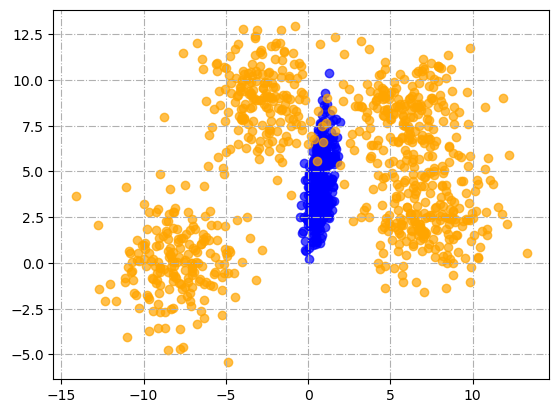

In [29]:
# VAE SEEMS TO HAVE GENERALIZED MORE TO DATA IT HAS CONVERGED TO A GLOBAL AVERAGE

x_rec,mu,sigma=vae(X_train.reshape(-1,40))
zeta=x_rec.reshape(400,-1)

plt.scatter(zeta[:,0].detach().numpy(),zeta[:,1].detach().numpy(),color='b',alpha=0.7)
plt.scatter(X_train[:,0].detach().numpy(),X_train[:,1].detach().numpy(),color='orange',alpha=0.7)
plt.grid(linestyle='-.')

In [30]:
enc,dec=auto(X_test)
beta1=dec

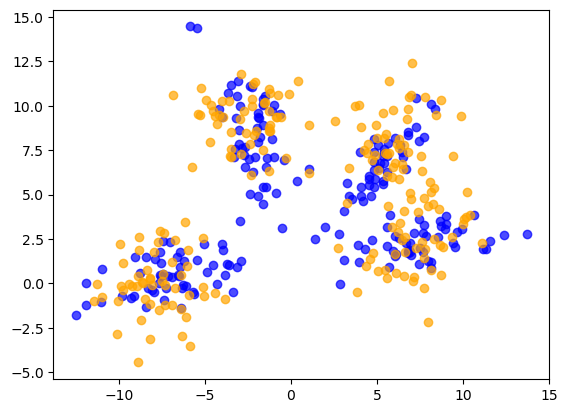

In [31]:
plt.scatter(beta1[:,0].detach().numpy(),beta1[:,1].detach().numpy(),color='b',alpha=0.7)
plt.scatter(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),color='orange',alpha=0.7)

In [32]:
plt.scatter(zeta1[:,0].detach().numpy(),zeta1[:,1].detach().numpy(),color='b',alpha=0.7)
plt.scatter(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),color='orange',alpha=0.7)

NameError: name 'zeta1' is not defined

In [33]:
from sklearn.cluster import KMeans,DBSCAN

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f397179b5e0>
Traceback (most recent call last):
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>

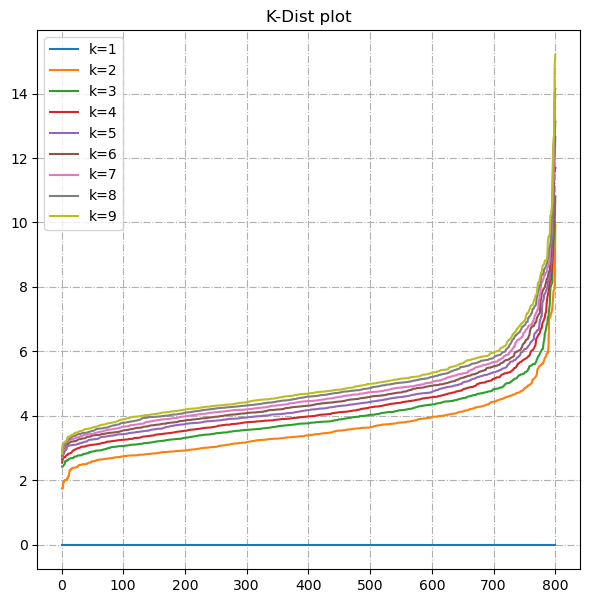

In [34]:
##CREATING A K-DIST PLOT

from sklearn.neighbors import NearestNeighbors
plt.figure(figsize=(7,7))
for k in range(1,10):           # VALUES OF K NEIGHBOURS

    # INITIALIZE NEAREST NEIGHBOURS EUCLIDEAN METHOD AND FIT ON DATA
    nbrs=NearestNeighbors(metric="euclidean",n_neighbors=k,n_jobs=-1).fit(beta.detach().numpy())
    
    # FIND THE INDEX AND DISTANCES TO THE K NEIGHBOURS 
    dist,index=nbrs.kneighbors(beta.detach().numpy())

    # FROM DISTANCES FIND DISTANCE TO Kth NEIGHBOUR
    k_dist=dist[:,-1]

    # SORT VALUES IN ASCENDING ORDER
    k_dist=np.sort(k_dist)
    
    plt.plot(np.arange(1,len(k_dist)+1),k_dist,label=f"k={k}")
    
plt.grid(linestyle='-.')
plt.title("K-Dist plot")
plt.legend()
plt.show()
    

In [35]:
dbscan=DBSCAN(eps=0.1,min_samples=5)
dbscan.fit(beta.detach().numpy())
labels=dbscan.labels_

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f397179b4c0>
Traceback (most recent call last):
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [36]:
import pandas as pd
import seaborn as sns
df=pd.DataFrame({'x1':beta[:,0].detach().numpy(),'x2':beta[:,1].detach().numpy(),\
                 'label':labels})

/home/ibrahim/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ibrahim/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ibrahim/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='x1', ylabel='x2'>

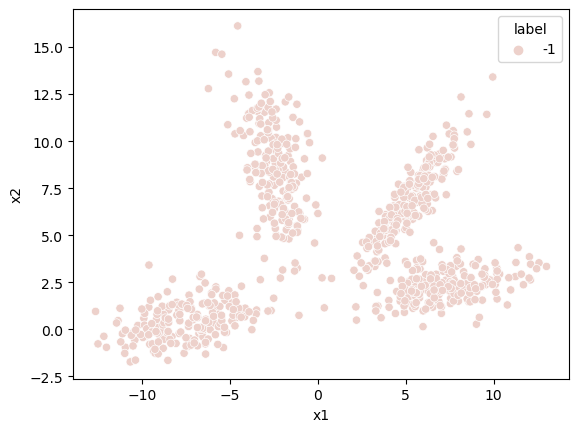

In [37]:
sns.scatterplot(data=df,x='x1',y='x2',hue='label')

In [38]:
wcss=[]
for n in range(1,9):
    km=KMeans(n_clusters=n,n_init='auto',verbose=False,random_state=42)
    km.fit(mu.detach().numpy(),sigma.detach().numpy())
    wcss.append(km.inertia_)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f39725cd9d0>
Traceback (most recent call last):
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>

In [39]:
wcss=[]
for n in range(1,9):
    km=KMeans(n_clusters=n,n_init='auto',verbose=False,random_state=42)
    km.fit(mu.detach().numpy(),sigma.detach().numpy())
    wcss.append(km.inertia_)
    
plt.plot(range(1,9),wcss,marker='o',color='r')
plt.grid(linestyle='-.')
plt.show()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f397179b4c0>
Traceback (most recent call last):
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ibrahim/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>

KeyboardInterrupt: 

In [ ]:
plt.plot(range(1,9),wcss,marker='o',color='r')
plt.grid(linestyle='-.')
plt.show()